# Prototype for the Blue Carbon Cost tool:

In [ ]:
import sys

sys.path.append("./src/bcc_model/")

# import libraries
<<<<<<< local
import pandas as pd  # noqa: I001
from blue_carbon_project import BlueCarbonProject
from cost_calculator import CostCalculator
import json
=======
import pandas as pd  # noqa: I001
>>>>>>> remote

In [ ]:
# Import excel with the import datai
<<<<<<< local
data_path = "./raw_data/data_ingestion.xlsm"
=======
data_path = "../../raw_data/data_ingestion.xlsm"
>>>>>>> remote

# Open the excel file - tab 'master_table'
master_table = pd.read_excel(data_path, sheet_name="master_table")

# Open the excel file - tab 'base_size_table'
base_size = pd.read_excel(data_path, sheet_name="base_size_table")

# Open the excel file - tab 'base_increase'
base_increase = pd.read_excel(data_path, sheet_name="base_increase")

base_size.head()

In [ ]:
<<<<<<< local
## EXAMPLE 1

# project_name = "Conservation_Mangrove_Indonesia"
# loss_rate_used = "project-specific"
# # Example usage for a restoration project
# Project = BlueCarbonProject(
#     activity="Conservation",  # ['Restoration', 'Conservation']
#     ecosystem="Mangrove",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
#     country="Indonesia",  # [
#     #'United States', 'Indonesia', 'Australia', 'The Bahamas', 'Kenya', 'Mexico',
#     # 'Colombia', 'India', 'China']
#     master_table=master_table,
#     base_size=base_size,
#     base_increase=base_increase,
#     carbon_price=20,  # Default value 30
#     carbon_revenues_to_cover="Opex",  # ['Opex', 'capex+Opex']
#     project_size_ha=10000,
#     # restoration_activity='Planting', # ['Planting', 'Hybrid', 'Hydrology']
#     # sequestration_rate_used='Tier 1 - IPCC default value', # ['Tier 1 - IPCC default value',
#     #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
#     # project_specific_sequestration_rate=None,
#     # planting_success_rate=0.8, # Default value 0.8
#     loss_rate_used="project-specific",  # ['National average', 'project-specific']
#     project_specific_loss_rate=-0.001, # -0.10% loss rate
#     emission_factor_used="Tier 2 - Country-specific emission factor",
#     # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
#     #  'Tier 3 - Project specific emission factor']
#     # tier_3_project_specific_emission="AGB and SOC separately",
#     # ['One emission factor', 'AGB and SOC separately']
#     # tier_3_project_specific_emission_one_factor=0.5,
#     # tier_3_emission_factor_AGB=0.5,
#     # tier_3_emission_factor_SOC=0.5
# )
=======
from blue_carbon_project import BlueCarbonProject

# Example usage for a restoration project
Project = BlueCarbonProject(
    activity="Conservation",  # ['Restoration', 'Conservation']
    ecosystem="Mangrove",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
    country="Caribbean",  # [
    #'United States', 'Indonesia', 'Australia', 'Caribbean', 'Kenya', 'Mexico',
    # 'Colombia', 'India', 'China']
    master_table=master_table,
    base_size=base_size,
    base_increase=base_increase,
    carbon_price=30,  # 30,  # Default value 30
    carbon_revenues_to_cover="Opex",  # ['Opex', 'capex+Opex']
    project_size_ha=40000,
    # restoration_activity='Planting', # ['Planting', 'Hybrid', 'Hydrology']
    # sequestration_rate_used='Tier 2 - Country-specific rate', # ['Tier 1 - IPCC default value',
    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
    # project_specific_sequestration_rate=None,
    # planting_success_rate=0.8, # Default value 0.8
    loss_rate_used="National average",  # ['National average', 'project-specific']
    # project_specific_loss_rate=-0.001,
    emission_factor_used="Tier 3 - Project specific emission factor",
    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
    #  'Tier 3 - Project specific emission factor']
    tier_3_project_specific_emission="One emission factor",
    # ['One emission factor', 'AGB and SOC separately']
    tier_3_project_specific_emission_one_factor=0.5,
    # tier_3_emission_factor_agb=0.5,
    # tier_3_emission_factor_soc=0.5
)
>>>>>>> remote

In [ ]:
# ### EXAMPLE 2

# project_name = "Restoration__China_Salt_marsh"
# loss_rate_used = "project-specific"
# # Example usage for a restoration project
# Project = BlueCarbonProject(
#     activity="Restoration",  # ['Restoration', 'Conservation']
#     ecosystem="Salt marsh",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
#     country="China",  # [
#     #'United States', 'Indonesia', 'Australia', 'The Bahamas', 'Kenya', 'Mexico',
#     # 'Colombia', 'India', 'China']
#     master_table=master_table,
#     base_size=base_size,
#     base_increase=base_increase,
#     carbon_price=30,  # Default value 30
#     carbon_revenues_to_cover="Opex",  # ['Opex', 'capex+Opex']
#     project_size_ha=500,
#     restoration_activity='Hydrology', # ['Planting', 'Hybrid', 'Hydrology']
#     sequestration_rate_used='Tier 1 - IPCC default value', # ['Tier 1 - IPCC default value',
#     #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
#     # project_specific_sequestration_rate=None,
#     planting_success_rate=0.8, # Default value 0.8
#     # loss_rate_used="project-specific",  # ['National average', 'project-specific']
#     # project_specific_loss_rate=-0.001, # -0.10% loss rate
#     # emission_factor_used="Tier 2 - Country-specific emission factor",
#     # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
#     #  'Tier 3 - Project specific emission factor']
#     # tier_3_project_specific_emission="AGB and SOC separately",
#     # ['One emission factor', 'AGB and SOC separately']
#     # tier_3_project_specific_emission_one_factor=0.5,
#     # tier_3_emission_factor_AGB=0.5,
#     # tier_3_emission_factor_SOC=0.5
# )

In [ ]:
### EXAMPLE 3

project_name = "Restoration_Mexico_Mangrove"
# loss_rate_used = "project-specific"
# Example usage for a restoration project
Project = BlueCarbonProject(
    activity="Restoration",  # ['Restoration', 'Conservation']
    ecosystem="Mangrove",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
    country="Mexico",  # [
    #'United States', 'Indonesia', 'Australia', 'The Bahamas', 'Kenya', 'Mexico',
    # 'Colombia', 'India', 'China']
    master_table=master_table,
    base_size=base_size,
    base_increase=base_increase,
    carbon_price=30,  # Default value 30
    carbon_revenues_to_cover="capex+Opex",  # ['Opex', 'capex+Opex']
    project_size_ha=500,
    restoration_activity="Planting",  # ['Planting', 'Hybrid', 'Hydrology']
    sequestration_rate_used="Tier 2 - Country-specific rate",  # ['Tier 1 - IPCC default value',
    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
    # project_specific_sequestration_rate=None,
    planting_success_rate=0.8,  # Default value 0.8
    # loss_rate_used="project-specific",  # ['National average', 'project-specific']
    # project_specific_loss_rate=-0.001, # -0.10% loss rate
    # emission_factor_used="Tier 2 - Country-specific emission factor",
    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
    #  'Tier 3 - Project specific emission factor']
    # tier_3_project_specific_emission="AGB and SOC separately",
    # ['One emission factor', 'AGB and SOC separately']
    # tier_3_project_specific_emission_one_factor=0.5,
    # tier_3_emission_factor_AGB=0.5,
    # tier_3_emission_factor_SOC=0.5
)

In [ ]:
# Project.set_additional_assumptions(
#     # verification_frequency,
#     # discount_rate,
#     # carbon_price_increase,
#     buffer=0.28,
#     # baseline_reassessment_frequency,
#     conservation_project_length=30,
#     # restoration_project_length,
#     # restoration_rate
# )

# Project.override_cost_input(
#     feasibility_analysis=30000
#     # conservation_planning_and_admin,
#     # data_collection_and_field_cost,
#     # community_representation,
#     # blue_carbon_project_planning,
#     # establishing_carbon_rights,
#     # validation,
#     # implementation_labor,
#     # monitoring,
#     # maintenance,
#     # community_benefit_sharing_fund,
#     # carbon_standard_fees,
#     # baseline_reassessment,
#     # MRV,
#     # long_term_project_operating,
#     # financing_cost
# )

In [ ]:
project_params = Project.get_project_parameters()
cost_calculator = CostCalculator(Project)
cost_summary = cost_calculator.get_summary()
cost_estimates = cost_calculator.get_cost_estimates()

df = cost_calculator.get_yearly_cost_breakdown()
df

<<<<<<< local <removed>


{'Activity': 'Conservation',
 'Ecosystem': 'Mangrove',
 'Country': 'Caribbean',
 'Country codee': 'BHS',
 'Project size (ha)': 40000,
 'Initial carbon price assumption ($)': 30,
 'Carbon revenues to cover': 'Opex',
 'Carbon revenues will not cover': 'Capex',
 'Conservation additional parameters': {'Loss rate used': 'National average',
  'National average': -0.00732054025426532,
  'Emission factor used': 'Tier 3 - Project specific emission factor',
  'Global emission factor': None,
  'Country-specific emission factors': None,
  'Tier 3 - Project-specific emissions - one emission factor or separate AGB and SOC': 'One emission factor',
  'Tier 3 - Emission factor (One)': 0.5,
  'Tier 3 - AGB and SOC separately': None},
 'Additional assumptions': {'Verification frequency (years)': 5,
  'Discount rate (%)': 4.0,
  'Carbon price increase (%)': 1.5,
  'Buffer (%)': 20,
  'Baseline reassessment frequency (years)': 10,
  'For Conservation projects only': {'Conservation project length (yr)': 20}

>>>>>>> remote <modified: text/plain>


In [19]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
from cost_calculator import CostCalculator

cost_calculator = CostCalculator(Project)

In [7]:
cost_calculator.get_summary()

{'Project': 'Indonesia Mangrove\n             Conservation (10000 ha)',
 '$/tCO2e (total cost, NPV)': '$16',
 '$/ha': '$358',
 'NPV covering cost': '$392,807',
 'IRR when priced to cover opex': '18.5%',
 'IRR when priced to cover total costs': '-1.1%',
 'Total cost (NPV)': '$3,576,251',
 'Capital expenditure (NPV)': '$1,268,099',
 'Operating expenditure (NPV)': '$2,308,151',
 'Credits issued': '225,700',
 'Total revenue (NPV)': '$2,700,959',
 'Total revenue (non-discounted)': '$5,862,020',
 'Financing cost': '$67,590',
 'Funding gap (NPV)': '$0',
 'Funding gap per tCO2e (NPV)': '$0.0',
 'Community benefit sharing fund % of revenue': '\n            50%'}

In [8]:
# total avoided emissions
# annual avoided emissions
from sequestration_credits_calculator import SequestrationCreditsCalculator

sequestration_credits_calculator = SequestrationCreditsCalculator(Project)

sequestration_credits_calculator.calculate_abatement_potential()

962944.928098755

In [8]:
cost_calculator.get_cost_estimates()

,Cost estimates (USD),Total cost,NPV
0,Capital expenditure,"$1,351,800","$1,268,099"
1,Feasibility analysis,"$30,000","$30,000"
2,Conservation planning and admin,"$667,067","$629,559"
3,Data collection and field costs,"$80,000","$76,963"
4,Community representation / liaison,"$284,733","$268,724"
5,Blue carbon project planning,"$100,000","$88,900"
6,Establishing carbon rights,"$140,000","$129,504"
7,Validation,"$50,000","$44,450"
8,Implementation labor,$0,$0
9,Operating expenditure,"$4,828,150","$2,308,151"


In [9]:
df = cost_calculator.get_yearly_cost_breakdown()
df

,-4,-3,-2,-1,1,2,3,4,5,6,...,23,24,25,26,27,28,29,30,Total,NPV
Feasibility analysis,-30000.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-30000.00,-30000.0
Conservation planning and admin,-166767.0,-166767.0,-166767.0,-166767.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-667067.00,-629559.0
Data collection and field costs,-26667.0,-26667.0,-26667.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-80000.00,-76963.0
Community representation / liaison,-71183.0,-71183.0,-71183.0,-71183.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-284733.00,-268724.0
Blue carbon project planning,0.0,0.0,0.0,-100000.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-100000.00,-88900.0
Establishing carbon rights,0.0,-46667.0,-46667.0,-46667.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-140000.00,-129504.0
Validation,0.0,0.0,0.0,-50000.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,-50000.00,-44450.0
Implementation labor,0.0,0.0,0.0,-0.0,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.0,-0.0,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.0
Total capex,-294617.0,-311283.0,-311283.0,-434617.0,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.0,-0.0,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-1351800.00,-1268099.0
Monitoring,0.0,0.0,0.0,0.0,-15000.00,-15000.00,-15000.00,-15000.00,-15000.00,-15000.00,...,-15000.0,-15000.0,-15000.00,-15000.00,-15000.00,-15000.00,-15000.00,-15000.00,-450000.00,-230588.0


In [ ]:
# Export to test_data to compare calculated results with expected ones
# df.to_csv("./test_data/Pro_forma_calculated_data.csv", index=False)

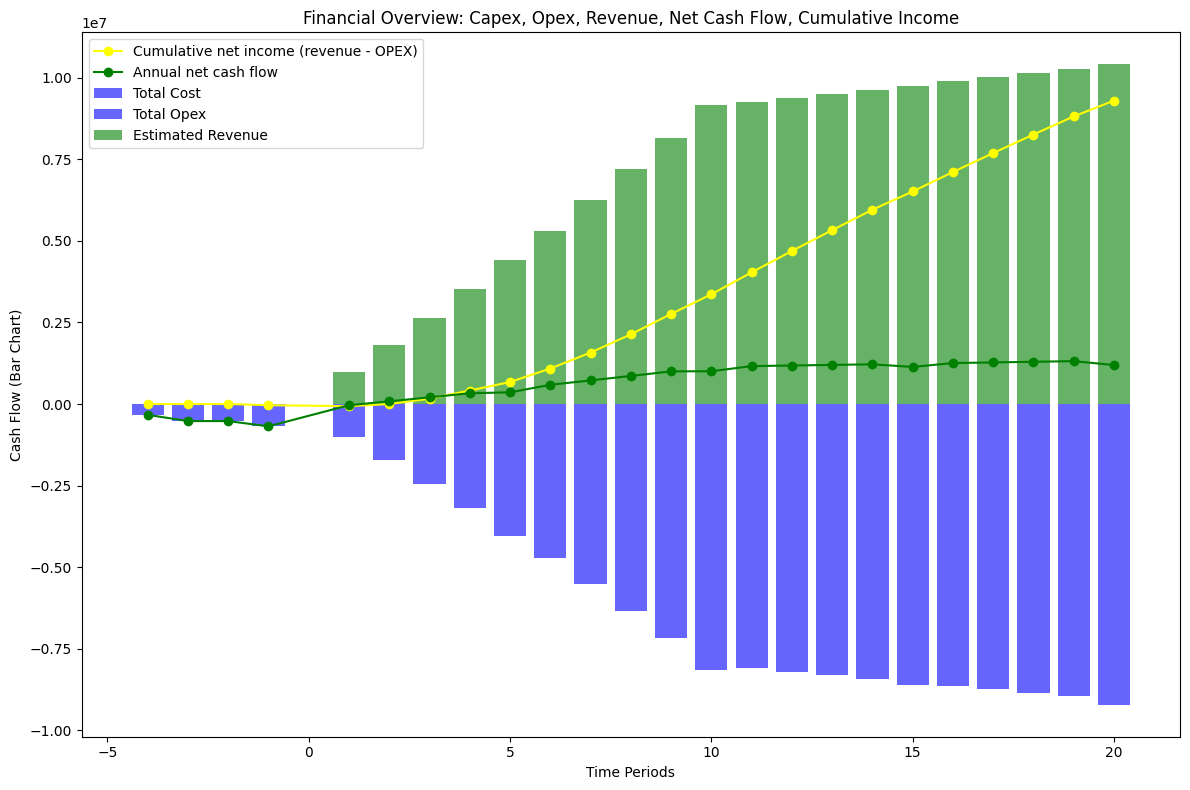

In [ ]:
cost_graph = cost_calculator.plot_financial_data()
cost_graph

# Calculate breakeven price:

Calculate carbon price to obtain NPV covering cost to zero.

In [ ]:
def calculate_breakeven_cost(project, max_iterations=100, tolerance=1e-5):
    """
    Function to calculate the breakeven cost of carbon
    """
    # Start the calculation with the initial carbon price
    carbon_price = Project.carbon_price

    for iteration in range(max_iterations):
        # Update the project carbon price and initialize cost calculator
        Project.carbon_price = carbon_price
        cost_calculator = CostCalculator(Project)

        # Calculate NPV covering cost
        npv_covering_cost = cost_calculator.NPV_covering_cost
        credits_issued = cost_calculator.credits_issued

        print(f"""Iteration {iteration}: NPV covering cost = {npv_covering_cost},
        Carbon price = {carbon_price}""")

        # Check if the NPV covering cost is within the acceptable tolerance
        if abs(npv_covering_cost) < tolerance:
            print("Converged successfully.")

            # Retrieve additional cost estimates and summary
            cost_summary = cost_calculator.get_summary()  # Assuming this method exists
            cost_estimates = cost_calculator.get_cost_estimates()  # Assuming this method exists
            project_params = Project.get_project_parameters()  # Assuming this method exists

            return {
                "breakeven_carbon_price": float(carbon_price),
                "project_params": project_params,
                "cost_summary": cost_summary,
                "cost_estimates": cost_estimates,
                "cost_pro_forma": cost_calculator.get_yearly_cost_breakdown(),
            }

        # Ensure credits_issued is not zero to avoid division errors
        if credits_issued == 0:
            print("Error: Credits issued are zero, breakeven cost cannot be calculated.")
            return None

        # Update carbon price based on the NPV covering cost and credits issued
        carbon_price -= npv_covering_cost / credits_issued

    # If max_iterations are reached without convergence, return the last calculated price
    print("Warning: Max iterations reached without convergence.")
    return {
        "breakeven_carbon_price": float(carbon_price),
        "project_params": Project.get_project_parameters(),
        "cost_summary": cost_calculator.get_summary(),
        "cost_estimates": cost_calculator.get_cost_estimates(),
        "cost_pro_forma": cost_calculator.get_yearly_cost_breakdown(),
    }

In [ ]:
# Calculate the breakeven cost
breakeven_cost = calculate_breakeven_cost(Project, max_iterations=150)
print(f"The breakeven cost is: {breakeven_cost}")

Iteration 0: NPV covering cost = 0.0011380687355995178,
        Carbon price = 7.092599750134778
Iteration 1: NPV covering cost = 0.0010249428451061249,
        Carbon price = 7.092599749856243
Iteration 2: NPV covering cost = 0.00092305988073349,
        Carbon price = 7.0925997496053945
Iteration 3: NPV covering cost = 0.0008313097059726715,
        Carbon price = 7.092599749379481
Iteration 4: NPV covering cost = 0.0007486715912818909,
        Carbon price = 7.092599749176023
Iteration 5: NPV covering cost = 0.0006742477416992188,
        Carbon price = 7.09259974899279
Iteration 6: NPV covering cost = 0.0006072260439395905,
        Carbon price = 7.092599748827772
Iteration 7: NPV covering cost = 0.0005468688905239105,
        Carbon price = 7.092599748679158
Iteration 8: NPV covering cost = 0.0004925094544887543,
        Carbon price = 7.0925997485453145
Iteration 9: NPV covering cost = 0.0004435442388057709,
        Carbon price = 7.092599748424776
Iteration 10: NPV covering cost

<span style="color:red"><b><<<<<<< local</b></span>

In [ ]:
# populate json with output values
output = {
    "initialCarbonPriceComputationOutput": {
        # Update for restoration projects and other definitions
        # "lossRate": project_params['Conservation additional parameters'][ 'project-specific'],
        "sequestrationRate": project_params["Restoration additional parameters"][
            "Tier 2 - Country-specific rate"
        ],
        "plantingSuccessRate": 0.8,
        "carbonRevenuesToCover": project_params["Carbon revenues to cover"],
        "initialCarbonPrice": project_params["Initial carbon price assumption ($)"],
        # "emissionFactors": {
        #     "emissionFactor": None,
        #     "emissionFactorAgb": project_params['Conservation additional parameters']['Country-specific emission factors']['Emission factor AGB'],  # noqa: E501
        #     "emissionFactorSoc": project_params['Conservation additional parameters']['Country-specific emission factors']['Emission factor SOC']  # noqa: E501
        # },
        "totalProjectCost": {
            "total": {
                "total": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "capex": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Capital expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "opex": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
            "npv": {
                "total": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "capex": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Capital expenditure", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "opex": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
        },
        "leftover": {
            # review when is OPEX + CAPEX
            "total": {
                "total": int(
                    cost_summary["Total revenue (non-discounted)"].replace("$", "").replace(",", "")
                ),
                "leftover": int(
                    cost_summary["Total revenue (non-discounted)"].replace("$", "").replace(",", "")
                )
                - int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                )
                if project_params["Carbon revenues to cover"] == "Opex"
                else int(
                    cost_summary["Total revenue (non-discounted)"].replace("$", "").replace(",", "")
                )
                - int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "opex": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                )
                if project_params["Carbon revenues to cover"] == "Opex"
                else int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
            "npv": {
                "total": int(cost_summary["Total revenue (NPV)"].replace("$", "").replace(",", "")),
                "leftover": int(
                    cost_summary["Total revenue (NPV)"].replace("$", "").replace(",", "")
                )
                - int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                )
                if project_params["Carbon revenues to cover"] == "Opex"
                else int(cost_summary["Total revenue (NPV)"].replace("$", "").replace(",", ""))
                - int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "opex": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                )
                if project_params["Carbon revenues to cover"] == "Opex"
                else int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
        },
        "summary": {
            "$/tCO2e (total cost, NPV)": int(
                cost_summary["$/tCO2e (total cost, NPV)"].replace("$", "").replace(",", "")
            ),
            "$/ha": int(cost_summary["$/ha"].replace("$", "").replace(",", "")),
            "NPV covering cost": int(
                cost_summary["NPV covering cost"].replace("$", "").replace(",", "")
            ),
            # double check this attribute - this value should be the same as the NPV covering cost so how is it used?  # noqa: E501
            "Leftover after OpEx / total cost": int(
                cost_summary["NPV covering cost"].replace("$", "").replace(",", "")
            ),
            "IRR when priced to cover OpEx": float(
                cost_summary["IRR when priced to cover opex"].replace("%", "")
            )
            / 100,
            "IRR when priced to cover total cost": float(
                cost_summary["IRR when priced to cover total costs"].replace("%", "")
            )
            / 100,
            "Total cost (NPV)": int(
                cost_summary["Total cost (NPV)"].replace("$", "").replace(",", "")
            ),
            "Capital expenditure (NPV)": int(
                cost_summary["Capital expenditure (NPV)"].replace("$", "").replace(",", "")
            ),
            "Operating expenditure (NPV)": int(
                cost_summary["Operating expenditure (NPV)"].replace("$", "").replace(",", "")
            ),
            "Credits issued": int(cost_summary["Credits issued"].replace(",", "")),
            "Total revenue (NPV)": int(
                cost_summary["Total revenue (NPV)"].replace("$", "").replace(",", "")
            ),
            "Total revenue (non-discounted)": int(
                cost_summary["Total revenue (non-discounted)"].replace("$", "").replace(",", "")
            ),
            "Financing cost": int(cost_summary["Financing cost"].replace("$", "").replace(",", "")),
            # dueble check - we should remove this and just show the fundin gap (NPV)
            "Funding gap": int(cost_summary["Funding gap (NPV)"].replace("$", "").replace(",", "")),
            "Funding gap (NPV)": int(
                cost_summary["Funding gap (NPV)"].replace("$", "").replace(",", "")
            ),
            "Funding gap per tCO2e (NPV)": float(
                cost_summary["Funding gap per tCO2e (NPV)"].replace("$", "").replace(",", "")
            ),
            "Community benefit sharing fund": int(
                cost_summary["Community benefit sharing fund % of revenue"]
                .replace("%", "")
                .replace(",", "")
            )
            / 100,
        },
        "costDetails": {
            "total": {
                "capitalExpenditure": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Capital expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "operationalExpenditure": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "totalCost": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "feasibilityAnalysis": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Feasibility analysis",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "conservationPlanningAndAdmin": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Conservation planning and admin",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "dataCollectionAndFieldCost": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Data collection and field costs",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "communityRepresentation": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"]
                        == "Community representation / liaison",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "blueCarbonProjectPlanning": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Blue carbon project planning",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "establishingCarbonRights": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Establishing carbon rights",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "validation": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Validation", "Total cost"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "implementationLabor": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Implementation labor",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "monitoring": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Monitoring", "Total cost"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "maintenance": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Maintenance", "Total cost"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "communityBenefitSharingFund": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Community benefit sharing fund",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "carbonStandardFees": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Carbon standard fees",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "baselineReassessment": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Baseline reassessment",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "mrv": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "MRV", "Total cost"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "longTermProjectOperatingCost": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Long-term project operating",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
            "npv": {
                "capitalExpenditure": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Capital expenditure", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "operationalExpenditure": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "totalCost": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "feasibilityAnalysis": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Feasibility analysis", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "conservationPlanningAndAdmin": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Conservation planning and admin",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "dataCollectionAndFieldCost": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Data collection and field costs",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "communityRepresentation": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"]
                        == "Community representation / liaison",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "blueCarbonProjectPlanning": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Blue carbon project planning",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "establishingCarbonRights": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Establishing carbon rights",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "validation": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Validation", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "implementationLabor": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Implementation labor", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "monitoring": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Monitoring", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "maintenance": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Maintenance", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "communityBenefitSharingFund": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Community benefit sharing fund",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "carbonStandardFees": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Carbon standard fees", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "baselineReassessment": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Baseline reassessment", "NPV"
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "mrv": int(
                    cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "MRV", "NPV"]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "longTermProjectOperatingCost": int(
                    cost_estimates.loc[
                        cost_estimates["Cost estimates (USD)"] == "Long-term project operating",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
        },
        "yearlyBreakdown": [
            {
                "costName": "feasibilityAnalysis",
                "totalCost": float(df.loc["Feasibility analysis"]["Total"]),
                "totalNPV": float(df.loc["Feasibility analysis"]["NPV"]),
                "costValues": dict(df.loc["Feasibility analysis"][:-2].items()),
            },
            {
                "costName": "conservationPlanningAndAdmin",
                "totalCost": float(df.loc["Conservation planning and admin"]["Total"]),
                "totalNPV": float(df.loc["Conservation planning and admin"]["NPV"]),
                "costValues": dict(df.loc["Conservation planning and admin"][:-2].items()),
            },
            {
                "costName": "dataCollectionAndFieldCost",
                "totalCost": float(df.loc["Data collection and field costs"]["Total"]),
                "totalNPV": float(df.loc["Data collection and field costs"]["NPV"]),
                "costValues": dict(df.loc["Data collection and field costs"][:-2].items()),
            },
            {
                "costName": "blueCarbonProjectPlanning",
                "totalCost": float(df.loc["Blue carbon project planning"]["Total"]),
                "totalNPV": float(df.loc["Blue carbon project planning"]["NPV"]),
                "costValues": dict(df.loc["Blue carbon project planning"][:-2].items()),
            },
            {
                "costName": "communityRepresentation",
                "totalCost": float(df.loc["Community representation / liaison"]["Total"]),
                "totalNPV": float(df.loc["Community representation / liaison"]["NPV"]),
                "costValues": dict(df.loc["Community representation / liaison"][:-2].items()),
            },
            {
                "costName": "establishingCarbonRights",
                "totalCost": float(df.loc["Establishing carbon rights"]["Total"]),
                "totalNPV": float(df.loc["Establishing carbon rights"]["NPV"]),
                "costValues": dict(df.loc["Establishing carbon rights"][:-2].items()),
            },
            {
                "costName": "validation",
                "totalCost": float(df.loc["Validation"]["Total"]),
                "totalNPV": float(df.loc["Validation"]["NPV"]),
                "costValues": dict(df.loc["Validation"][:-2].items()),
            },
            {
                "costName": "implementationLabor",
                "totalCost": float(df.loc["Implementation labor"]["Total"]),
                "totalNPV": float(df.loc["Implementation labor"]["NPV"]),
                "costValues": dict(df.loc["Implementation labor"][:-2].items()),
            },
            {
                "costName": "monitoring",
                "totalCost": float(df.loc["Monitoring"]["Total"]),
                "totalNPV": float(df.loc["Monitoring"]["NPV"]),
                "costValues": dict(df.loc["Monitoring"][:-2].items()),
            },
            {
                "costName": "maintenance",
                "totalCost": float(df.loc["Maintenance"]["Total"]),
                "totalNPV": float(df.loc["Maintenance"]["NPV"]),
                "costValues": dict(df.loc["Maintenance"][:-2].items()),
            },
            {
                "costName": "communityBenefitSharingFund",
                "totalCost": float(df.loc["Community benefit sharing fund"]["Total"]),
                "totalNPV": float(df.loc["Community benefit sharing fund"]["NPV"]),
                "costValues": dict(df.loc["Community benefit sharing fund"][:-2].items()),
            },
            {
                "costName": "carbonStandardFees",
                "totalCost": float(df.loc["Carbon standard fees"]["Total"]),
                "totalNPV": float(df.loc["Carbon standard fees"]["NPV"]),
                "costValues": dict(df.loc["Carbon standard fees"][:-2].items()),
            },
            {
                "costName": "baselineReassessment",
                "totalCost": float(df.loc["Baseline reassessment"]["Total"]),
                "totalNPV": float(df.loc["Baseline reassessment"]["NPV"]),
                "costValues": dict(df.loc["Baseline reassessment"][:-2].items()),
            },
            {
                "costName": "mrv",
                "totalCost": float(df.loc["MRV"]["Total"]),
                "totalNPV": float(df.loc["MRV"]["NPV"]),
                "costValues": dict(df.loc["MRV"][:-2].items()),
            },
            {
                "costName": "longTermProjectOperatingCost",
                "totalCost": float(df.loc["Long-term project operating"]["Total"]),
                "totalNPV": float(df.loc["Long-term project operating"]["NPV"]),
                "costValues": dict(df.loc["Long-term project operating"][:-2].items()),
            },
            {
                "costName": "opexTotalCostPlan",
                "totalCost": float(df.loc["Total opex"]["Total"]),
                "totalNPV": float(df.loc["Total opex"]["NPV"]),
                "costValues": dict(df.loc["Total opex"][:-2].items()),
            },
            {
                "costName": "capexTotalCostPlan",
                "totalCost": float(df.loc["Total capex"]["Total"]),
                "totalNPV": float(df.loc["Total capex"]["NPV"]),
                "costValues": dict(df.loc["Total capex"][:-2].items()),
            },
            {
                "costName": "totalCostPlan",
                "totalCost": float(df.loc["Total cost"]["Total"]),
                "totalNPV": float(df.loc["Total cost"]["NPV"]),
                "costValues": dict(df.loc["Total cost"][:-2].items()),
            },
            {
                "costName": "estimatedRevenuePlan",
                "totalCost": float(df.loc["Est. revenue"]["Total"]),
                "totalNPV": float(df.loc["Est. revenue"]["NPV"]),
                "costValues": dict(df.loc["Est. revenue"][:-2].items()),
            },
            {
                "costName": "creditsIssuedPlan",
                "totalCost": float(df.loc["Est. credits issued"]["Total"]),
                "totalNPV": float(df.loc["Est. credits issued"]["NPV"]),
                "costValues": dict(df.loc["Est. credits issued"][:-2].items()),
            },
            {
                "costName": "cumulativeNetIncomePlan",
                "totalCost": float(df.loc["Cumulative net income (revenue - OPEX)"]["Total"]),
                "totalNPV": float(df.loc["Cumulative net income (revenue - OPEX)"]["NPV"]),
                "costValues": dict(df.loc["Cumulative net income (revenue - OPEX)"][:-2].items()),
            },
            {
                "costName": "cumulativeNetIncomeCapexOpex",
                "totalCost": float(
                    df.loc["Cumulative net income (revenue - CAPEX - OPEX)"]["Total"]
                ),
                "totalNPV": float(df.loc["Cumulative net income (revenue - CAPEX - OPEX)"]["NPV"]),
                "costValues": dict(
                    df.loc["Cumulative net income (revenue - CAPEX - OPEX)"][:-2].items()
                ),
            },
            {
                "costName": "annualNetCashFlow",
                "totalCost": float(df.loc["Annual net cash flow"]["Total"]),
                "totalNPV": float(df.loc["Annual net cash flow"]["NPV"]),
                "costValues": dict(df.loc["Annual net cash flow"][:-2].items()),
            },
            {
                "costName": "annualNetIncome",
                "totalCost": float(df.loc["Annual net income (revenue – OPEX)"]["Total"]),
                "totalNPV": float(df.loc["Annual net income (revenue – OPEX)"]["NPV"]),
                "costValues": dict(df.loc["Annual net income (revenue – OPEX)"][:-2].items()),
            },
        ],
    },
    "breakevenPriceComputationOutput": {
        # Update values as first element of the list
        # "lossRate": breakeven_cost['project_params']['Conservation additional parameters'][ 'project-specific'],  # noqa: E501
        "carbonRevenuesToCover": breakeven_cost["project_params"]["Carbon revenues to cover"],
        "sequestrationRate": project_params["Restoration additional parameters"][
            "Tier 2 - Country-specific rate"
        ],
        "plantingSuccessRate": 0.8,
        "initialCarbonPrice": float(
            breakeven_cost["project_params"]["Initial carbon price assumption ($)"]
        ),
        # "emissionFactors": {
        #     "emissionFactor": None,
        #     "emissionFactorAgb": breakeven_cost['project_params']['Conservation additional parameters']['Country-specific emission factors']['Emission factor AGB'],  # noqa: E501
        #     "emissionFactorSoc": breakeven_cost['project_params']['Conservation additional parameters']['Country-specific emission factors']['Emission factor SOC']  # noqa: E501
        # },
        "totalProjectCost": {
            "total": {
                "total": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "capex": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Capital expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "opex": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Operating expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
            "npv": {
                "total": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "capex": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Capital expenditure",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "opex": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Operating expenditure",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
        },
        "leftover": {
            "total": {
                "total": int(
                    breakeven_cost["cost_summary"]["Total revenue (non-discounted)"]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "leftover": int(
                    breakeven_cost["cost_summary"]["Total revenue (non-discounted)"]
                    .replace("$", "")
                    .replace(",", "")
                )
                - int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Operating expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                )
                if breakeven_cost["project_params"]["Carbon revenues to cover"] == "Opex"
                else int(
                    breakeven_cost["cost_summary"]["Total revenue (non-discounted)"]
                    .replace("$", "")
                    .replace(",", "")
                )
                - int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "opex": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Operating expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                )
                if breakeven_cost["project_params"]["Carbon revenues to cover"] == "Opex"
                else int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
            "npv": {
                "total": int(
                    breakeven_cost["cost_summary"]["Total revenue (NPV)"]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "leftover": int(
                    breakeven_cost["cost_summary"]["Total revenue (NPV)"]
                    .replace("$", "")
                    .replace(",", "")
                )
                - int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Operating expenditure",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                )
                if breakeven_cost["project_params"]["Carbon revenues to cover"] == "Opex"
                else int(
                    breakeven_cost["cost_summary"]["Total revenue (NPV)"]
                    .replace("$", "")
                    .replace(",", "")
                )
                - int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "opex": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Operating expenditure",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                )
                if breakeven_cost["project_params"]["Carbon revenues to cover"] == "Opex"
                else int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
        },
        "summary": {
            "$/tCO2e (total cost, NPV)": int(
                breakeven_cost["cost_summary"]["$/tCO2e (total cost, NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "$/ha": int(breakeven_cost["cost_summary"]["$/ha"].replace("$", "").replace(",", "")),
            "NPV covering cost": int(
                breakeven_cost["cost_summary"]["NPV covering cost"]
                .replace("$", "")
                .replace(",", "")
            ),
            # double check this attribute - this value should be the same as the NPV covering cost so how is it used?  # noqa: E501
            "Leftover after OpEx / total cost": int(
                breakeven_cost["cost_summary"]["NPV covering cost"]
                .replace("$", "")
                .replace(",", "")
            ),
            "IRR when priced to cover OpEx": float(
                breakeven_cost["cost_summary"]["IRR when priced to cover opex"].replace("%", "")
            )
            / 100,
            "IRR when priced to cover total cost": float(
                breakeven_cost["cost_summary"]["IRR when priced to cover total costs"].replace(
                    "%", ""
                )
            )
            / 100,
            "Total cost (NPV)": int(
                breakeven_cost["cost_summary"]["Total cost (NPV)"].replace("$", "").replace(",", "")
            ),
            "Capital expenditure (NPV)": int(
                cost_summary["Capital expenditure (NPV)"].replace("$", "").replace(",", "")
            ),
            "Operating expenditure (NPV)": int(
                cost_summary["Operating expenditure (NPV)"].replace("$", "").replace(",", "")
            ),
            "Credits issued": int(
                breakeven_cost["cost_summary"]["Credits issued"].replace(",", "")
            ),
            "Total revenue (NPV)": int(
                breakeven_cost["cost_summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "Total revenue (non-discounted)": int(
                breakeven_cost["cost_summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "Financing cost": int(
                breakeven_cost["cost_summary"]["Financing cost"].replace("$", "").replace(",", "")
            ),
            # dueble check - we should remove this and just show the fundin gap (NPV)
            "Funding gap": int(
                breakeven_cost["cost_summary"]["Funding gap (NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "Funding gap (NPV)": int(
                breakeven_cost["cost_summary"]["Funding gap (NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "Funding gap per tCO2e (NPV)": float(
                breakeven_cost["cost_summary"]["Funding gap per tCO2e (NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "Community benefit sharing fund": int(
                breakeven_cost["cost_summary"]["Community benefit sharing fund % of revenue"]
                .replace("%", "")
                .replace(",", "")
            )
            / 100,
        },
        "costDetails": {
            "total": {
                "capitalExpenditure": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Capital expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "operationalExpenditure": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Operating expenditure",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "totalCost": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "feasibilityAnalysis": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Feasibility analysis",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "conservationPlanningAndAdmin": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Conservation planning and admin",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "dataCollectionAndFieldCost": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Data collection and field costs",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "communityRepresentation": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Community representation / liaison",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "blueCarbonProjectPlanning": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Blue carbon project planning",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "establishingCarbonRights": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Establishing carbon rights",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "validation": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Validation",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "implementationLabor": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Implementation labor",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "monitoring": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Monitoring",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "maintenance": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Maintenance",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "communityBenefitSharingFund": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Community benefit sharing fund",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "carbonStandardFees": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Carbon standard fees",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "baselineReassessment": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Baseline reassessment",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "mrv": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "MRV",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "longTermProjectOperatingCost": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Long-term project operating",
                        "Total cost",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
            "npv": {
                "capitalExpenditure": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Capital expenditure",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "operationalExpenditure": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Operating expenditure",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "totalCost": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "feasibilityAnalysis": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Feasibility analysis",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "conservationPlanningAndAdmin": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Conservation planning and admin",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "dataCollectionAndFieldCost": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Data collection and field costs",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "communityRepresentation": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Community representation / liaison",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "blueCarbonProjectPlanning": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Blue carbon project planning",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "establishingCarbonRights": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Establishing carbon rights",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "validation": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Validation",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "implementationLabor": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Implementation labor",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "monitoring": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Monitoring",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "maintenance": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Maintenance",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "communityBenefitSharingFund": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Community benefit sharing fund",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "carbonStandardFees": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Carbon standard fees",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "baselineReassessment": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Baseline reassessment",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "mrv": int(
                    breakeven_cost["cost_estimates"]
                    .loc[breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "MRV", "NPV"]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
                "longTermProjectOperatingCost": int(
                    breakeven_cost["cost_estimates"]
                    .loc[
                        breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                        == "Long-term project operating",
                        "NPV",
                    ]
                    .values[0]
                    .replace("$", "")
                    .replace(",", "")
                ),
            },
        },
        "yearlyBreakdown": [
            {
                "costName": "feasibilityAnalysis",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"][:-2].items()
                ),
            },
            {
                "costName": "conservationPlanningAndAdmin",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Conservation planning and admin"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Conservation planning and admin"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"]
                    .loc["Conservation planning and admin"][:-2]
                    .items()
                ),
            },
            {
                "costName": "dataCollectionAndFieldCost",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Data collection and field costs"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Data collection and field costs"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"]
                    .loc["Data collection and field costs"][:-2]
                    .items()
                ),
            },
            {
                "costName": "blueCarbonProjectPlanning",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Blue carbon project planning"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Blue carbon project planning"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"]
                    .loc["Blue carbon project planning"][:-2]
                    .items()
                ),
            },
            {
                "costName": "communityRepresentation",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Community representation / liaison"][
                        "Total"
                    ]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Community representation / liaison"][
                        "NPV"
                    ]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"]
                    .loc["Community representation / liaison"][:-2]
                    .items()
                ),
            },
            {
                "costName": "establishingCarbonRights",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"][:-2].items()
                ),
            },
            {
                "costName": "validation",
                "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Validation"]["Total"]),
                "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Validation"]["NPV"]),
                "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Validation"][:-2].items()),
            },
            {
                "costName": "implementationLabor",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Implementation labor"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Implementation labor"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Implementation labor"][:-2].items()
                ),
            },
            {
                "costName": "monitoring",
                "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Monitoring"]["Total"]),
                "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Monitoring"]["NPV"]),
                "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Monitoring"][:-2].items()),
            },
            {
                "costName": "maintenance",
                "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Maintenance"]["Total"]),
                "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Maintenance"]["NPV"]),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Maintenance"][:-2].items()
                ),
            },
            {
                "costName": "communityBenefitSharingFund",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Community benefit sharing fund"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Community benefit sharing fund"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"]
                    .loc["Community benefit sharing fund"][:-2]
                    .items()
                ),
            },
            {
                "costName": "carbonStandardFees",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"][:-2].items()
                ),
            },
            {
                "costName": "baselineReassessment",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"][:-2].items()
                ),
            },
            {
                "costName": "mrv",
                "totalCost": float(breakeven_cost["cost_pro_forma"].loc["MRV"]["Total"]),
                "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["MRV"]["NPV"]),
                "costValues": dict(breakeven_cost["cost_pro_forma"].loc["MRV"][:-2].items()),
            },
            {
                "costName": "longTermProjectOperatingCost",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Long-term project operating"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Long-term project operating"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Long-term project operating"][:-2].items()
                ),
            },
            {
                "costName": "opexTotalCostPlan",
                "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total opex"]["Total"]),
                "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total opex"]["NPV"]),
                "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Total opex"][:-2].items()),
            },
            {
                "costName": "capexTotalCostPlan",
                "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total capex"]["Total"]),
                "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total capex"]["NPV"]),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Total capex"][:-2].items()
                ),
            },
            {
                "costName": "totalCostPlan",
                "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total cost"]["Total"]),
                "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total cost"]["NPV"]),
                "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Total cost"][:-2].items()),
            },
            {
                "costName": "estimatedRevenuePlan",
                "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Est. revenue"]["Total"]),
                "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Est. revenue"]["NPV"]),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Est. revenue"][:-2].items()
                ),
            },
            {
                "costName": "creditsIssuedPlan",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Est. credits issued"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Est. credits issued"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Est. credits issued"][:-2].items()
                ),
            },
            {
                "costName": "cumulativeNetIncomePlan",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Cumulative net income (revenue - OPEX)"][
                        "Total"
                    ]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Cumulative net income (revenue - OPEX)"][
                        "NPV"
                    ]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"]
                    .loc["Cumulative net income (revenue - OPEX)"][:-2]
                    .items()
                ),
            },
            {
                "costName": "cumulativeNetIncomeCapexOpex",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc[
                        "Cumulative net income (revenue - CAPEX - OPEX)"
                    ]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc[
                        "Cumulative net income (revenue - CAPEX - OPEX)"
                    ]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"]
                    .loc["Cumulative net income (revenue - CAPEX - OPEX)"][:-2]
                    .items()
                ),
            },
            {  # sum of total cost + est revenue
                "costName": "annualNetCashFlow",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"]["Total"]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"]["NPV"]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"][:-2].items()
                ),
            },
            {  # sum total opex + est revenue
                "costName": "annualNetIncome",
                "totalCost": float(
                    breakeven_cost["cost_pro_forma"].loc["Annual net income (revenue – OPEX)"][
                        "Total"
                    ]
                ),
                "totalNPV": float(
                    breakeven_cost["cost_pro_forma"].loc["Annual net income (revenue – OPEX)"][
                        "NPV"
                    ]
                ),
                "costValues": dict(
                    breakeven_cost["cost_pro_forma"]
                    .loc["Annual net income (revenue – OPEX)"][:-2]
                    .items()
                ),
            },
        ],
    },
}

output

# export output as json file
with open(f"./test_data/output_{project_name}.json", "w") as f:
    json.dump(output, f)

<span style="color:red"><b>=======</b></span>

In [35]:
# TOtal cost
cost_calculator.total_NPV

3576250.5665318407

In [14]:
Project.get_sequestration_rate()

ValueError: Sequestration rate can only be calculated for restoration projects.

<span style="color:red"><b>>>>>>>> remote</b></span>